# Global Wheat Head Detection 

# Introduction

Object detection is one of the most important topics of computer vision since it has many applications in several fields. One application of it is this amazing challenge.

Object detection models can be improved thanks to ensemble techniques.

However, the process of ensembling object detectors poses
several challenges including the selection of models but most importantly the way of ensembling itself. Because different models have different output types with different confidence range which requires some 'work'. 

We had the initiative to ensemble YOLOv5x model with EfficientDet5 and doing some hacks to make it optimal!

# EfficientDet5

## EfficientDet Architecture 

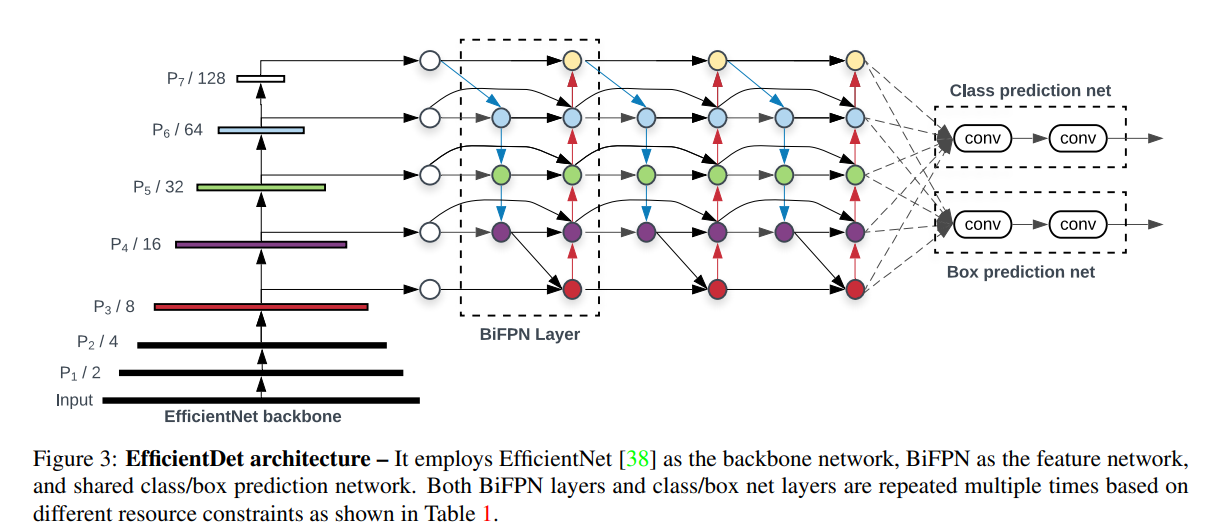

## EfficientDet ModelFlops vs COCO accuracy

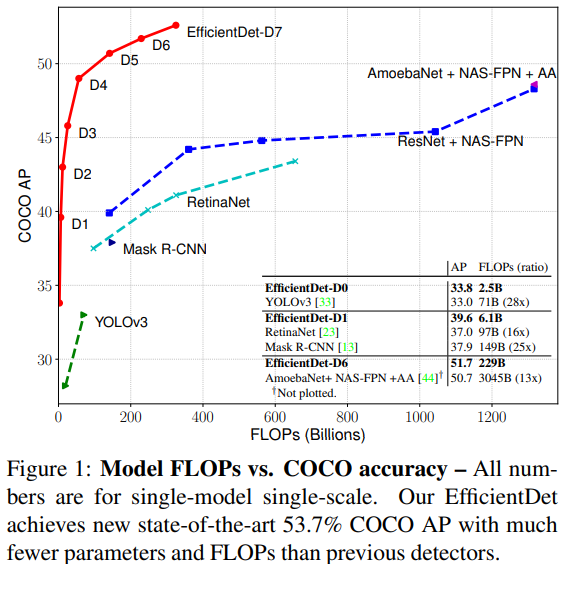

In [ ]:
# Dependencies

!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null





import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")



import ensemble_boxes
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet




def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)




DATA_ROOT_PATH = '../input/global-wheat-detection/test'




class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image_size, width, _ = image.shape
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id, image_size

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    
    
    
    
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)




def collate_fn(batch):
    return tuple(zip(*batch))





data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)




'''
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()




net = load_net('../input/efficientdet5f0/best-checkpoint-028epoch.bin')
'''




class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAContrastBrightness(BaseWheatTTA):
    """ author: @ffares """

    def augment(self, image):
        alpha = round(random.uniform(1, 1.3),2) # Contrast control// alpha value [1.0-3.0]
        beta = round(random.uniform(0, 0.2),2)  # Brightness control// beta value [0-100]
        return torch.clamp(torch.add(torch.mul(image,alpha),beta),0, 1, out=None)
    
    def batch_augment(self, images):
        alpha = round(random.uniform(1, 1.3),2) # Contrast control// alpha value [1.0-3.0]
        beta = round(random.uniform(0, 0.2),2)  # Brightness control// beta value [0-100]
        return torch.clamp(torch.add(torch.mul(images,alpha),beta),0, 255, out=None)
    
    def deaugment_boxes(self, boxes):
        return boxes
        
class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes
    
class TTARotate180(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 2, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 2, (2, 3))
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,1,2,3]] = self.image_size - boxes[:, [2,3,0,1]]
        return boxes
    
class TTARotate270(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 3, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 3, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = boxes[:, [1,3]]
        res_boxes[:, [1,3]] = self.image_size - boxes[:, [2,0]]
        return res_boxes
    
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)
    
    
    
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))
    

def load_net5(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

def load_net7(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d7')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()



## Ensemble different EfficientDet Models
### Different architectures 
### Or, same architectures but trained on different folds & using different augmentations


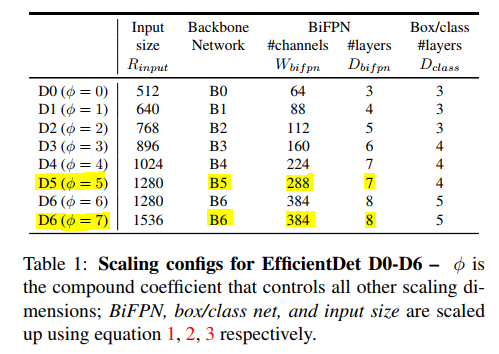

In [ ]:
# Models
models =[    
    #With Cleaning/ Old Version fold 0
    load_net5('../input/efficientdetearlierversionf0/best-checkpoint-047epoch.bin'), 
    #With Cleaning/ New Version fold 0
    load_net5('../input/efficientdet5f0/best-checkpoint-028epoch.bin'), 
    #With CLEANING fold 1 fine tuned on half arvalis
    #load_net5('../input/efficientdet5f1finetunearv2/best-checkpoint-001epoch.bin'), 
    #Without Cleaning fold 3
    #load_net7('../input/training-efficientdet-f3/effdet5-cutmix-augmix/best-checkpoint-033epoch.bin'),
    #Without Cleaning fold 4
    load_net7('../input/training-efficientdet-f4/effdet5-cutmix-augmix/best-checkpoint-037epoch.bin'), 
]
    

def make_predictions(images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]
  
    
def make_tta_predictions(images, score_threshold=0.25):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions


def make_tta_models_predictions(images, score_threshold=0.25):
    images = torch.stack(images).float().cuda()
    with torch.no_grad():
        predictions = []
        for tta_transform in tta_transforms:
            for net in models:
                result = []
                det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())
                for i in range(images.shape[0]):
                    boxes = det[i].detach().cpu().numpy()[:,:4]    
                    scores = det[i].detach().cpu().numpy()[:,4]
                    indexes = np.where(scores > score_threshold)[0]
                    boxes = boxes[indexes]
                    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                    boxes = tta_transform.deaugment_boxes(boxes.copy())
                    
                    result.append({
                        'boxes': boxes,
                        'scores': scores[indexes],
                    })
                predictions.append(result)
    return predictions

def make_models_predictions(images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    for net in models:
        with torch.no_grad():
            det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
            result = []
            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                result.append({
                    'boxes': boxes[indexes],
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions


# Inference 
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [ ]:
def calibrate(liste, conf_max=0.91):
    '''
    This method is essential to callibrate the bounding boxes confidence of an algorithm
    This is important to make ensembling more efficient
    Input: List of probablities with maximimum p_max
    Output: List of probablities with maximum conf_max
    '''
    m=max(liste)

    if m<conf_max: 
        alpha=conf_max-m

        for i in range(len(liste)):
            liste[i]+=alpha
    
    return liste


def normalize(liste):
    '''
    This method is essential to normalize the bounding boxes confidence of an algorithm
    This is important to make ensembling more efficient
    Input: List of initial probablities 
    Output: List of probablities normalized
    '''
    maximum = max(liste)
    minimum = min(liste)
    
    for i in range(len(liste)):
        liste[i]= (liste[i]-minimum) / (maximum-minimum) 

    return liste


In [ ]:

def resize_predicitions(predictions): 
    '''
    Resize bboxes of efficient det as it predicts bboxes in the range of 512 
    We need to double the predicitions
    '''
    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            predictions[i][j]['boxes']=predictions[i][j]['boxes']*2
        
    return predictions


def effdet_organize(predictions, image_index):
    
    boxes = [(prediction[image_index]['boxes']).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    
    if 0:
        for i in range(len(scores)): 
            scores[i]=normalize(scores[i])
        
    return boxes, scores, labels


def yolo_organize(boxes,scores):
    
    boxes_output=[]
    for i in range(len(boxes[0])):
        boxes_output.append(boxes[0][i].tolist())
    
    scores_output=[]
    for i in range(len(scores[0])):
        scores_output.append(scores[0][i].cpu().float().item())   
        
    # Calibrate if 1    
    if 0:
        scores_output = calibrate(scores_output)
        
    # Normalize if 1
    if 0:
        scores_output = normalize(scores_output)
    
    labels_output = [1]*len(scores_output)
    
    return [boxes_output], [scores_output], [labels_output]

def run_wbf_ensemble(boxes_effdet, boxes_yolo, scores_effdet, scores_yolo, labels_effdet, labels_yolo, iou_thr=0.6, skip_box_thr=0.5, weights=None):    
        
    boxes = boxes_effdet + boxes_yolo
    scores = scores_effdet + scores_yolo
    labels = labels_effdet + labels_yolo
    
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    return boxes, scores, labels



def run_wbf(boxes, scores, labels, iou_thr=0.5, skip_box_thr=0.3, weights=None):    
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    return boxes, scores, labels  


def run_wbf_initial(boxes,scores, image_size=1024, iou_thr=0.41, skip_box_thr=0.4, weights=None):
    labels0 = [np.ones(len(scores[idx])) for idx in range(len(scores))]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels0, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    return boxes, scores, labels

In [ ]:
for images, image_ids, image_size in data_loader:
    
    #predictions = make_tta_predictions(images)
    predictions = make_tta_models_predictions(images)
    #predictions = make_predictions(images)
    predictions=resize_predicitions(predictions)

    for i, image in enumerate(images):
        
        image_id=image_ids[i]

        
        # boxes using efficientdet5
        boxes_effdet, scores_effdet, labels_effdet = effdet_organize(predictions, image_index=i)
        
        boxes, scores, labels = run_wbf(boxes_effdet, scores_effdet, labels_effdet, iou_thr=0.6, skip_box_thr=0.5, weights=None)

        boxes = (boxes/2).round().astype(np.int32).clip(min=0, max=512)

    
    
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    
        sample = images[i].permute(1,2,0).cpu().numpy()
    
        font = cv2.FONT_HERSHEY_SIMPLEX 
    
        # fontScale 
        fontScale = 1

        # Blue color in RGB 
        color = (0, 0, 1) 

        # Line thickness of 2 px 
        thickness = 2

        for box,score in zip(boxes,scores):
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 0, 1), 1)
            cv2.putText(sample, '{:.2}'.format(score), (box[0]+np.random.randint(20),box[1]), font, fontScale, color, thickness, cv2.LINE_AA)
    
        ax.set_axis_off()
        ax.imshow(sample);
    
        break

# YOLOv5

## YOLOv5 Comparaison

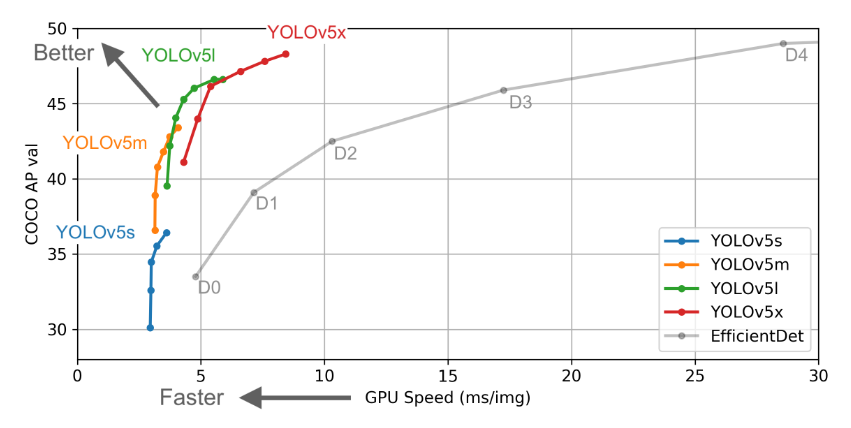

In [ ]:
sys.path.insert(0, "../input/yolov5tta/")
sys.path.insert(0, "../input/configyolov5")
#sys.path.insert(0, "../input/yolov5/")

import sys
import glob
import argparse
from utils.datasets import *
from utils.utils import *



def detect(save_img=False):
    weights, imgsz = opt.weights,opt.img_size
    source = '../input/global-wheat-detection/test/'
    
    # Initialize
    device = torch_utils.select_device(opt.device)
    half = True
    # Load model

    model = torch.load(weights, map_location=device)['model'].to(device).eval()

    dataset = LoadImages(source, img_size=1024)

    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    all_path=[]
    all_bboxex =[]
    all_score =[]
    for path, img, im0s, vid_cap in dataset:
        print(im0s.shape)
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = torch_utils.time_synchronized()
        bboxes_2 = []
        score_2 = []
        if True:
            pred = model(img, augment=opt.augment)[0]
            
            #Skip this?
            pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres,merge=True, classes=None, agnostic=False)
            
            t2 = torch_utils.time_synchronized()

            bboxes = []
            score = []
            # Process detections
            for i, det in enumerate(pred):  # detections per image
                p, s, im0 = path, '', im0s
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  #  normalization gain whwh
                if det is not None and len(det):
                    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class

                    for *xyxy, conf, cls in det:
                        if True:  # Write to file
                            xywh = torch.tensor(xyxy).view(-1).numpy()  
                            bboxes.append(xywh)
                            score.append(conf)
                            
            bboxes_2.append(bboxes)
            
            #add calibration while append
            #score_2.append(calibrate(score))
            score_2.append(score)
            
        all_path.append(path)
        all_score.append(score_2)
        all_bboxex.append(bboxes_2)
    return all_path,all_score,all_bboxex



if __name__ == '__main__':
    class opt:
        weights = "../input/train-continuity-yolov5x/weights/best_yolov5_fold0.pt"
        img_size = 1024
        conf_thres = 0.3
        iou_thres = 0.94 #0.94
        augment = True
        device = '0'
        classes=None
        agnostic_nms = True
        
    opt.img_size = check_img_size(opt.img_size)
    #print(opt)

    with torch.no_grad():
        res = detect()
        

all_path,all_score,all_bboxex = res

In [ ]:
for images, image_ids, image_sizes in data_loader:
    
    #predictions = make_tta_predictions(images)
    predictions = make_tta_models_predictions(images)
    #predictions = make_predictions(images)
    predictions=resize_predicitions(predictions)

    for i, image in enumerate(images):
        
        image_id=image_ids[i]
        

        
        # boxes using yolov5
        for row in range(len(all_path)):
            image_id_yolo = all_path[row].split("/")[-1].split(".")[0]
            if image_id_yolo==image_id:
                boxes_yolo = all_bboxex[row]
                scores_yolo = all_score[row]
                
            
                boxes_yolo, scores_yolo, labels_yolo = yolo_organize(boxes_yolo,scores_yolo)

        
        boxes, scores, labels =run_wbf(boxes_yolo, scores_yolo, labels_yolo, iou_thr=0.41, skip_box_thr=0.4, weights=None)

        boxes = (boxes/2).round().astype(np.int32).clip(min=0, max=512)

    
    
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    
        sample = images[i].permute(1,2,0).cpu().numpy()
    
        font = cv2.FONT_HERSHEY_SIMPLEX 
    
        # fontScale 
        fontScale = 1

        # Blue color in RGB 
        color = (0, 0, 1) 

        # Line thickness of 2 px 
        thickness = 2

        for box,score in zip(boxes,scores):
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 0, 1), 1)
            cv2.putText(sample, '{:.2}'.format(score), (box[0]+np.random.randint(20),box[1]), font, fontScale, color, thickness, cv2.LINE_AA)
    
        ax.set_axis_off()
        ax.imshow(sample);
    
        break

# Why not ensemble both? 

## WBF Ensemble EfficientDet & YOLOv5 

## Most Important Hyperparameters 

* IOU Threshold 

* Confidence Threshold

## Inference

In [ ]:
results = []

for images, image_ids, image_sizes in data_loader:
    #predictions = make_tta_predictions(images)
    predictions = make_tta_models_predictions(images)
    #predictions = make_models_predictions(images)
    #predictions = make_predictions(images)
    predictions=resize_predicitions(predictions)
    
    for i, image in enumerate(images):
        
        image_id=image_ids[i]
        image_size= image_sizes[i]
        
        # YOLOv5 predictions
        for row in range(len(all_path)):
            image_id_yolo = all_path[row].split("/")[-1].split(".")[0]
            if image_id_yolo==image_id:
                boxes_yolo_init = all_bboxex[row]
                scores_yolo_init = all_score[row]
                
                boxes_yolo, scores_yolo, labels_yolo = yolo_organize(boxes_yolo_init,scores_yolo_init)

                
        
        # EfficientDet predictions
        boxes_effdet, scores_effdet, labels_effdet = effdet_organize(predictions, image_index=i)
        
        
        # Fusion of both predictions
        boxes, scores, labels = run_wbf_ensemble(boxes_effdet, boxes_yolo, scores_effdet, scores_yolo, labels_effdet, 
                                                 labels_yolo, iou_thr=0.41, skip_box_thr=0.4, weights=None)
        
        boxes = (boxes*(image_size/1024)).round().astype(np.int32).clip(min=0, max=image_size-1)
        
        
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)
        

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head(10)

In [ ]:
for images, image_ids, image_sizes in data_loader:
    
    #predictions = make_tta_predictions(images)
    predictions = make_tta_models_predictions(images)
    #predictions = make_predictions(images)
    predictions=resize_predicitions(predictions)

    for i, image in enumerate(images):
        
        image_id=image_ids[i]
        
        image_size= image_sizes[i]
        
        # boxes using yolov5
        for row in range(len(all_path)):
            image_id_yolo = all_path[row].split("/")[-1].split(".")[0]
            if image_id_yolo==image_id:
                boxes_yolo = all_bboxex[row]
                scores_yolo = all_score[row]
                
            
                boxes_yolo, scores_yolo, labels_yolo = yolo_organize(boxes_yolo,scores_yolo)

        
        # boxes using efficientdet5
        boxes_effdet, scores_effdet, labels_effdet = effdet_organize(predictions, image_index=i)
        
        boxes, scores, labels = run_wbf_ensemble(boxes_effdet, boxes_yolo, scores_effdet, scores_yolo, labels_effdet, 
                                                 labels_yolo, iou_thr=0.41, skip_box_thr=0.4, weights=None)

        boxes = (boxes/2).round().astype(np.int32).clip(min=0, max=512)

    
    
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    
        sample = images[i].permute(1,2,0).cpu().numpy()
    
        font = cv2.FONT_HERSHEY_SIMPLEX 
    
        # fontScale 
        fontScale = 1

        # Blue color in RGB 
        color = (0, 0, 1) 

        # Line thickness of 2 px 
        thickness = 2

        for box,score in zip(boxes,scores):
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 0, 1), 1)
            cv2.putText(sample, '{:.2}'.format(score), (box[0]+np.random.randint(20),box[1]), font, fontScale, color, thickness, cv2.LINE_AA)
    
        ax.set_axis_off()
        ax.imshow(sample);
    
        break

# Refrences 

https://arxiv.org/abs/1911.09070

https://github.com/rwightman/efficientdet-pytorch

https://github.com/rwightman/pytorch-image-models

https://arxiv.org/pdf/2004.10934

https://github.com/ultralytics/yolov5

https://arxiv.org/abs/1910.13302

https://github.com/ZFTurbo/Weighted-Boxes-Fusion

https://www.kaggle.com/shonenkov/inference-efficientdet

https://www.kaggle.com/wasupandceacar/yolov5-single-model-with-more-tta-lb-0-745


## Thank you for reading my kernel!